In [1]:
from keras import backend as K
from keras.models import load_model
from keras.preprocessing import image
from keras.optimizers import Adam
from scipy.misc import imread
import numpy as np
from matplotlib import pyplot as plt

from keras_ssd300 import ssd_300
from keras_ssd_loss import SSDLoss
from keras_layer_AnchorBoxes import AnchorBoxes
from keras_layer_L2Normalization import L2Normalization
from ssd_box_encode_decode_utils import decode_y, decode_y2
from ssd_batch_generator import BatchGenerator

%matplotlib inline

Using TensorFlow backend.
/root/anaconda3/lib/python3.6/importlib/_bootstrap.py:205: RuntimeWarning: compiletime version 3.5 of module 'tensorflow.python.framework.fast_tensor_util' does not match runtime version 3.6
  return f(*args, **kwds)


In [2]:
import cv2
import numpy as np

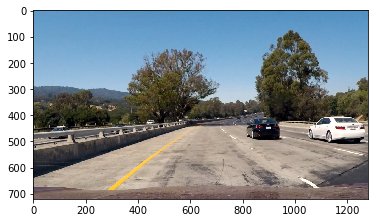

In [47]:
img = cv2.cvtColor(cv2.imread('test_images/test1.jpg'), cv2.COLOR_RGB2BGR)
plt.imshow(img)

In [10]:
img.shape

(720, 1280, 3)

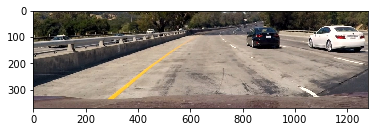

In [48]:
img_cropped = img[350:img.shape[0], :, :]
plt.imshow(img_cropped)

In [7]:
# Set the image size.
img_height = 300
img_width = 300

In [28]:
K.clear_session()
model = ssd_300(image_size=(img_height, img_width, 3),
                n_classes=20,
                l2_regularization=0.0005,
                scales=[0.1, 0.2, 0.37, 0.54, 0.71, 0.88, 1.05], # The scales for MS COCO are [0.07, 0.15, 0.33, 0.51, 0.69, 0.87, 1.05]
                aspect_ratios_per_layer=[[1.0, 2.0, 0.5],
                                         [1.0, 2.0, 0.5, 3.0, 1.0/3.0],
                                         [1.0, 2.0, 0.5, 3.0, 1.0/3.0],
                                         [1.0, 2.0, 0.5, 3.0, 1.0/3.0],
                                         [1.0, 2.0, 0.5],
                                         [1.0, 2.0, 0.5]],
                two_boxes_for_ar1=True,
                steps=[8, 16, 32, 64, 100, 300],
                offsets=[0.5, 0.5, 0.5, 0.5, 0.5, 0.5],
                limit_boxes=False,
                variances=[0.1, 0.1, 0.2, 0.2],
                coords='centroids',
                normalize_coords=True,
                subtract_mean=[123, 117, 104],
                swap_channels=True)

In [29]:
weights_path = 'models/VGG_VOC0712_SSD_300x300_iter_120000.h5'
model.load_weights(weights_path, by_name=True)
adam = Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-08, decay=5e-04)

ssd_loss = SSDLoss(neg_pos_ratio=3, n_neg_min=0, alpha=1.0)

model.compile(optimizer=adam, loss=ssd_loss.compute_loss)

In [30]:
model.save('models/ssd300keras.h5')

In [18]:
predict = model.predict(np.array([img_cropped]))

In [19]:
predict.shape

(1, 45616, 33)

In [20]:
y_pred_decoded = decode_y(predict,
                          confidence_thresh=0.5,
                          iou_threshold=0.45,
                          top_k=200,
                          input_coords='centroids',
                          normalize_coords=True,
                          img_height=img_height,
                          img_width=img_width)

np.set_printoptions(precision=2, suppress=True, linewidth=90)
print("Predicted boxes:\n")
print('    class    conf  xmin     ymin   xmax    ymax')
print(y_pred_decoded[0])

Predicted boxes:

    class    conf  xmin     ymin   xmax    ymax
[[    7.       1.     799.12    46.66   965.74   151.08]
 [    7.       1.    1013.59    42.17  1290.77   174.87]
 [    7.       0.53    49.4     85.93   171.13   149.23]]


In [5]:
classes = ['background',
           'aeroplane', 'bicycle', 'bird', 'boat',
           'bottle', 'bus', 'car', 'cat',
           'chair', 'cow', 'diningtable', 'dog',
           'horse', 'motorbike', 'person', 'pottedplant',
           'sheep', 'sofa', 'train', 'tvmonitor']

In [22]:
# Define a function to draw bounding boxes
def draw_boxes(img, bboxes, color=(0, 0, 255), thick=6):
    # Make a copy of the image
    imcopy = np.copy(img)
    # Iterate through the bounding boxes
    for bbox in bboxes:
        # Draw a rectangle given bbox coordinates
        cv2.rectangle(imcopy, bbox[0], bbox[1], color, thick)
    # Return the image copy with boxes drawn
    return imcopy


In [23]:
img_out = np.copy(img)
for box in y_pred_decoded[0]:
    # Transform the predicted bounding boxes for the 300x300 image to the original image dimensions.
    xmin = box[-4]# * orig_images[0].shape[1] / img_width
    ymin = box[-3]# * orig_images[0].shape[0] / img_height
    xmax = box[-2]# * orig_images[0].shape[1] / img_width
    ymax = box[-1]# * orig_images[0].shape[0] / img_height
    objclass = box[0]
    if objclass== 7:
        draw_boxes(img_out, (xmin, ymin + 350 ), (xmax, ymax + 350))
#     color = colors[int(box[0])]
#     label = '{}: {:.2f}'.format(classes[int(box[0])], box[1])
#     current_axis.add_patch(plt.Rectangle((xmin, ymin), xmax-xmin, ymax-ymin, color=color, fill=False, linewidth=2))  
#     current_axis.text(xmin, ymin, label, size='x-large', color='white', bbox={'facecolor':color, 'alpha':1.0})

IndexError: invalid index to scalar variable.

In [25]:
img_out = np.copy(img)
for box in y_pred_decoded[0]:
    # Transform the predicted bounding boxes for the 300x300 image to the original image dimensions.
    xmin = box[-4]# * orig_images[0].shape[1] / img_width
    ymin = box[-3]# * orig_images[0].shape[0] / img_height
    xmax = box[-2]# * orig_images[0].shape[1] / img_width
    ymax = box[-1]# * orig_images[0].shape[0] / img_height
    objclass = box[0]
    if objclass== 7:
        cv2.rectangle(img_out, (np.int(xmin), np.int(ymin + 350) ), (np.int(xmax),np.int(ymax + 350)), (0, 0, 255), 6)
#     color = colors[int(box[0])]
#     label = '{}: {:.2f}'.format(classes[int(box[0])], box[1])
#     current_axis.add_patch(plt.Rectangle((xmin, ymin), xmax-xmin, ymax-ymin, color=color, fill=False, linewidth=2))  
#     current_axis.text(xmin, ymin, label, size='x-large', color='white', bbox={'facecolor':color, 'alpha':1.0})

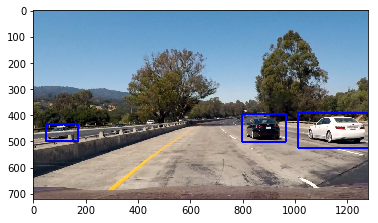

In [26]:
plt.imshow(img_out)

In [64]:
def pipeline(image):
    img_cropped = image[350:image.shape[0], :, :]
    img_input = cv2.resize(img_cropped, (300, 300))
    predict = model.predict(np.array([img_input]))
    y_pred_decoded = decode_y(predict,
                          confidence_thresh=0.5,
                          iou_threshold=0.45,
                          top_k=200,
                          input_coords='centroids',
                          normalize_coords=True,
                          img_height=300,
                          img_width=300)

    for box in y_pred_decoded[0]:
        # Transform the predicted bounding boxes for the 300x300 image to the original image dimensions.
        xmin = box[-4] * image.shape[1] / 300
        ymin = box[-3] * (image.shape[0] -350) / 300
        xmax = box[-2] * image.shape[1] / 300
        ymax = box[-1] * (image.shape[0]-350 )/ 300
        objclass = box[0]
        if objclass== 7:
            cv2.rectangle(image, (np.int(xmin), np.int(ymin + 350) ), (np.int(xmax),np.int(ymax + 350)), (0, 0, 255), 6)
    return image

In [58]:
testimg2 = cv2.cvtColor(cv2.imread('test_images/test1.jpg'), cv2.COLOR_RGB2BGR)


In [59]:
predict2 = pipeline(testimg2)


[[   7.      1.    242.84   40.66  295.96  126.5 ]
 [   7.      0.89  190.23   47.95  224.04  118.54]]
1036.09741211 50.1465722919 1262.75283813 156.018359363
811.6355896 59.1397368908 955.922698975 146.193196177


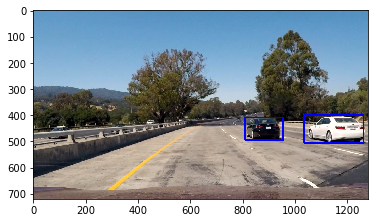

In [60]:
plt.imshow(predict2)

In [61]:
def video(fname, mimetype):
    from IPython.display import HTML
    video_encoded = open(fname, "rb").read().encode("base64")
    video_tag = '<video controls alt="test" src="data:video/{0};base64,{1}">'.format(mimetype, video_encoded)
    return HTML(data=video_tag)


In [66]:
from moviepy.editor import VideoFileClip
video_output = 'test_ssd_output.mp4'
clip1 = VideoFileClip('project_video.mp4')
clip_out = clip1.fl_image(pipeline)
%time clip_out.write_videofile(video_output, audio=False, progress_bar=False, verbose=False)

CPU times: user 1min 21s, sys: 17.8 s, total: 1min 39s
Wall time: 1min 41s


In [68]:
%%HTML

<video controls>
    <source src="test_ssd_output.mp4" type="video/mp4"/>
</video>

In [70]:
# experimenting with params
K.clear_session()
model = ssd_300(image_size=(img_height, img_width, 3),
                n_classes=20,
                l2_regularization=0.0005,
                scales=[0.1, 0.2, 0.37, 0.54, 0.71, 0.88, 1.05], # The scales for MS COCO are [0.07, 0.15, 0.33, 0.51, 0.69, 0.87, 1.05]
                aspect_ratios_per_layer=[[1.0, 2.0, 0.5],
                                         [1.0, 2.0, 0.5, 3.0, 1.0/3.0],
                                         [1.0, 2.0, 0.5, 3.0, 1.0/3.0],
                                         [1.0, 2.0, 0.5, 3.0, 1.0/3.0],
                                         [1.0, 2.0, 0.5],
                                         [1.0, 2.0, 0.5]], # as per original paper
                two_boxes_for_ar1=True,
                steps=[8, 16, 32, 64, 100, 300],
                offsets=[0.5, 0.5, 0.5, 0.5, 0.5, 0.5],
                limit_boxes=False,
                variances=[0.1, 0.1, 0.2, 0.2],
                coords='centroids',
                normalize_coords=True,
                subtract_mean=[123, 117, 104],
                swap_channels=True)
weights_path = 'models/VGG_VOC0712_SSD_300x300_iter_120000.h5'
model.load_weights(weights_path, by_name=True)
adam = Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-08, decay=5e-04)

ssd_loss = SSDLoss(neg_pos_ratio=3, n_neg_min=0, alpha=1.0)

model.compile(optimizer=adam, loss=ssd_loss.compute_loss)

In [71]:
img_input = cv2.resize(img_cropped, (300, 300))
predict = model.predict(np.array([img_input]))

In [82]:
img_copy = np.copy(img)
y_pred_decoded = decode_y(predict,
                          confidence_thresh=0.2,
                          iou_threshold=0.30,
                          top_k=200,
                          input_coords='centroids',
                          normalize_coords=True,
                          img_height=300,
                          img_width=300)

for box in y_pred_decoded[0]:
    # Transform the predicted bounding boxes for the 300x300 image to the original image dimensions.
    xmin = box[-4] * img.shape[1] / 300
    ymin = box[-3] * (img.shape[0] -350) / 300
    xmax = box[-2] * img.shape[1] / 300
    ymax = box[-1] * (img.shape[0]-350 )/ 300
    objclass = box[0]
    if objclass== 7:
        cv2.rectangle(img_copy, (np.int(xmin), np.int(ymin + 350) ), (np.int(xmax),np.int(ymax + 350)), (0, 0, 255), 6)


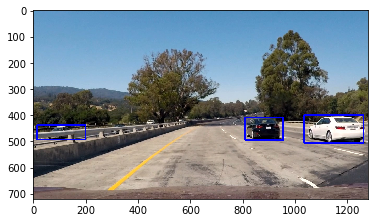

In [83]:
plt.imshow(img_copy)

In [84]:
def pipeline(image):
    img_cropped = image[350:image.shape[0], :, :]
    img_input = cv2.resize(img_cropped, (300, 300))
    predict = model.predict(np.array([img_input]))
    y_pred_decoded = decode_y(predict,
                          confidence_thresh=0.5,
                          iou_threshold=0.45,
                          top_k=200,
                          input_coords='centroids',
                          normalize_coords=True,
                          img_height=300,
                          img_width=300)

    for box in y_pred_decoded[0]:
        # Transform the predicted bounding boxes for the 300x300 image to the original image dimensions.
        xmin = box[-4] * image.shape[1] / 300
        ymin = box[-3] * (image.shape[0] -350) / 300
        xmax = box[-2] * image.shape[1] / 300
        ymax = box[-1] * (image.shape[0]-350 )/ 300
        objclass = box[0]
        if objclass== 7:
            cv2.rectangle(image, (np.int(xmin), np.int(ymin + 350) ), (np.int(xmax),np.int(ymax + 350)), (0, 0, 255), 6)
    return image

In [85]:
from moviepy.editor import VideoFileClip
video_output = 'test_ssd_output_confidence_thresh=0-2.mp4'
clip1 = VideoFileClip('project_video.mp4')
clip_out = clip1.fl_image(pipeline)
%time clip_out.write_videofile(video_output, audio=False, progress_bar=False, verbose=False)

CPU times: user 1min 19s, sys: 19.4 s, total: 1min 38s
Wall time: 1min 41s
